In [155]:
import numpy as np
import pandas as pd 

%matplotlib inline 
import matplotlib.pyplot as plt 

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# 0. Idée de manoeuvre pré-majoration

Y a eu un kaggle sur le sujet, on va donc s'en inspirer. (ce n'est pas le même dataset)
Voici le lien du kaggle: https://www.kaggle.com/c/home-credit-default-risk/overview

Voici un notebook introductif: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction

Voici un notebook avec un bon score: https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features

J'ai bien envie de combiner un neural network et un XGBoost, en général c'est bénèf. 

# 1. Exploration of the data

In [139]:
data = pd.read_csv('data/CreditTraining.csv', parse_dates=[3, 4, 13, 17])
data.head(5)

,Id_Customer,Y,Customer_Type,BirthDate,Customer_Open_Date,P_Client,Educational_Level,Marital_Status,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Sub_Category,Prod_Decision_Date,Source,Type_Of_Residence,Nb_Of_Products,Prod_Closed_Date,Prod_Category
0,7440,0,Non Existing Client,1977-07-08,2012-02-13,NP_Client,University,Married,3.0,1,36,1.0,C,2012-02-14,Sales,Owned,1,NaT,B
1,573,0,Existing Client,1974-06-13,2009-04-02,P_Client,University,Married,0.0,12,18,2.0,C,2011-06-30,Sales,Parents,1,NaT,G
2,9194,0,Non Existing Client,1973-07-11,2012-03-04,NP_Client,University,Married,2.0,10,36,1.0,C,2012-04-04,Sales,Owned,1,NaT,B
3,3016,1,Existing Client,1982-08-07,2011-08-25,NP_Client,University,Married,3.0,3,36,1.0,C,2011-07-09,Sales,New rent,1,2012-12-31,L
4,6524,0,Non Existing Client,1953-08-18,2012-10-01,NP_Client,University,Married,2.0,1,36,1.0,C,2012-11-01,Sales,Owned,1,NaT,D


In [140]:
# data.dtypes

In [141]:
data.shape

(5380, 19)

In [142]:
data['Net_Annual_Income']

0           36
1           18
2           36
3           36
4           36
         ...  
5375        36
5376    24,816
5377      14,4
5378        36
5379        30
Name: Net_Annual_Income, Length: 5380, dtype: object

On a un problème avec Net_Annual_Income qui est pas enregistré en float, ce qui est pas très pratique. Le problème c'est que pour l'enregistrer en float il faut changer les ',' en '.'.

In [143]:
data['Net_Annual_Income'] = data['Net_Annual_Income'].str.replace(',', '.').astype(float)

On trace des histogrammes pour les variables continues, voir si on observe quelque chose, peut-être des outliers...

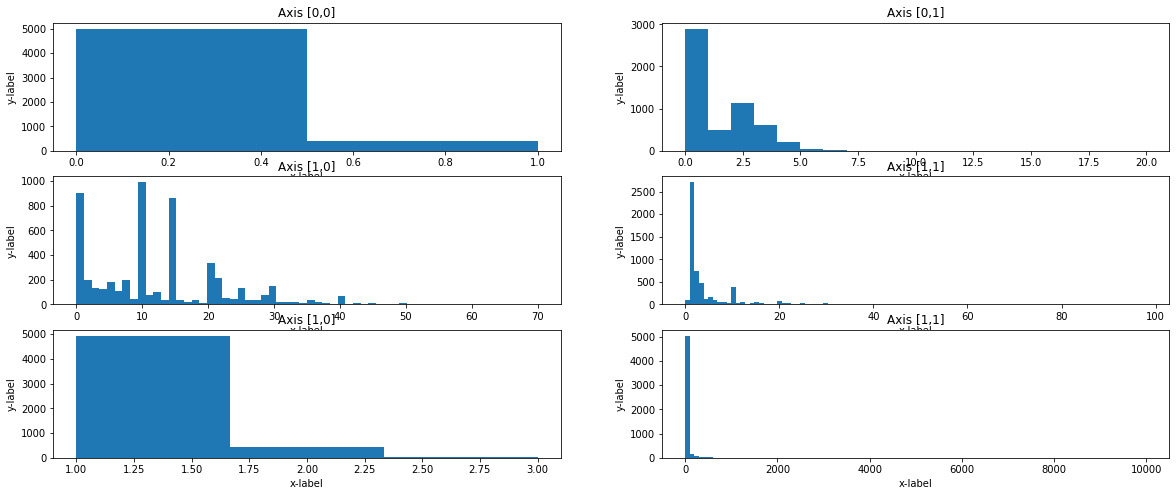

In [144]:
fig, axs = plt.subplots(3, 2, figsize=(20, 8))
axs[0, 0].hist(data['Y'], bins = 2)
axs[0, 0].set_title('Axis [0,0]')
axs[0, 1].hist(data['Number_Of_Dependant'], bins = 20)
axs[0, 1].set_title('Axis [0,1]')
axs[1, 0].hist(data['Years_At_Residence'], bins = 60)
axs[1, 0].set_title('Axis [1,0]')
axs[1, 1].hist(data['Years_At_Business'], bins = 100)
axs[1, 1].set_title('Axis [1,1]')
axs[2, 0].hist(data['Nb_Of_Products'], bins = 3)
axs[2, 0].set_title('Axis [1,0]')
axs[2, 1].hist(data['Net_Annual_Income'], bins = 100)
axs[2, 1].set_title('Axis [1,1]')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')
    
plt.show()

Intéressant de remarquer que pour la catégorie 'Years_At_Residence' on a des gros regroupements autour de 10,20 et 30, comme si on avait une grosse partie de gens qui arrondissaient sur ces valeurs là, peut-être que ca induit un certain biais.

In [145]:
print(data['Customer_Type'].value_counts())
print(data['P_Client'].value_counts())
print(data['Educational_Level'].value_counts())
print(data['Marital_Status'].value_counts())
print(data['Prod_Sub_Category'].value_counts())
print(data['Source'].value_counts())
print(data['Type_Of_Residence'].value_counts())
print(data['Prod_Category'].value_counts())

Non Existing Client    3369
Existing Client        2011
Name: Customer_Type, dtype: int64
NP_Client    4968
P_Client      412
Name: P_Client, dtype: int64
University           4785
Master/PhD            522
Diploma                58
Secondary or Less      15
Name: Educational_Level, dtype: int64
Married      4206
Single       1046
Widowed        64
Divorced       63
Separated       1
Name: Marital_Status, dtype: int64
C    4638
G     624
P     118
Name: Prod_Sub_Category, dtype: int64
Sales     4119
Branch    1261
Name: Source, dtype: int64
Owned       4791
Old rent     323
Parents      179
New rent      83
Company        4
Name: Type_Of_Residence, dtype: int64
B    3176
D     670
C     517
K     265
L     236
G     188
E     101
H      79
J      71
M      49
A      19
F       5
I       4
Name: Prod_Category, dtype: int64


On regarde aussi une description de tout ce qu'on a en variables categorielles (sauf les dates) pour voir la répartition de ce qu'on a.

La commande suivante permet de compter le nombre de valeurs manquantes pour chaque colonne.

In [146]:
data.isna().sum()

Id_Customer               0
Y                         0
Customer_Type             0
BirthDate                 0
Customer_Open_Date        0
P_Client                  0
Educational_Level         0
Marital_Status            0
Number_Of_Dependant       2
Years_At_Residence        0
Net_Annual_Income         2
Years_At_Business         2
Prod_Sub_Category         0
Prod_Decision_Date        0
Source                    0
Type_Of_Residence         0
Nb_Of_Products            0
Prod_Closed_Date       4206
Prod_Category             0
dtype: int64

# 2. Data transformation 

In [147]:
data.head()

,Id_Customer,Y,Customer_Type,BirthDate,Customer_Open_Date,P_Client,Educational_Level,Marital_Status,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Sub_Category,Prod_Decision_Date,Source,Type_Of_Residence,Nb_Of_Products,Prod_Closed_Date,Prod_Category
0,7440,0,Non Existing Client,1977-07-08,2012-02-13,NP_Client,University,Married,3.0,1,36.0,1.0,C,2012-02-14,Sales,Owned,1,NaT,B
1,573,0,Existing Client,1974-06-13,2009-04-02,P_Client,University,Married,0.0,12,18.0,2.0,C,2011-06-30,Sales,Parents,1,NaT,G
2,9194,0,Non Existing Client,1973-07-11,2012-03-04,NP_Client,University,Married,2.0,10,36.0,1.0,C,2012-04-04,Sales,Owned,1,NaT,B
3,3016,1,Existing Client,1982-08-07,2011-08-25,NP_Client,University,Married,3.0,3,36.0,1.0,C,2011-07-09,Sales,New rent,1,2012-12-31,L
4,6524,0,Non Existing Client,1953-08-18,2012-10-01,NP_Client,University,Married,2.0,1,36.0,1.0,C,2012-11-01,Sales,Owned,1,NaT,D


## Handle the dates

In [148]:
data['Customer_Open_Date'].max(), data['Prod_Decision_Date'].max(), data['Prod_Closed_Date'].max()

(Timestamp('2012-12-04 00:00:00'),
 Timestamp('2012-12-04 00:00:00'),
 Timestamp('2013-12-05 00:00:00'))

In [149]:
# it was n days in the past
data['Customer_Open_Date'] = data['Customer_Open_Date'].max() - data['Customer_Open_Date']

In [150]:
data['BirthDate'] = data['Prod_Closed_Date'].max() - data['BirthDate']

In [151]:
data['Prod_Decision_Date'] = data['Prod_Decision_Date'].max() - data['Prod_Decision_Date']

In [153]:
# get it to binary atm, could do something more precise after as it seems to be a very significant feature !
data['Prod_Closed_Date'] = data['Prod_Closed_Date'].isna()*(-1)+1

In [154]:
data.head()

,Id_Customer,Y,Customer_Type,BirthDate,Customer_Open_Date,P_Client,Educational_Level,Marital_Status,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Sub_Category,Prod_Decision_Date,Source,Type_Of_Residence,Nb_Of_Products,Prod_Closed_Date,Prod_Category
0,7440,0,Non Existing Client,13299 days,295 days,NP_Client,University,Married,3.0,1,36.0,1.0,C,294 days,Sales,Owned,1,0,B
1,573,0,Existing Client,14420 days,1342 days,P_Client,University,Married,0.0,12,18.0,2.0,C,523 days,Sales,Parents,1,0,G
2,9194,0,Non Existing Client,14757 days,275 days,NP_Client,University,Married,2.0,10,36.0,1.0,C,244 days,Sales,Owned,1,0,B
3,3016,1,Existing Client,11443 days,467 days,NP_Client,University,Married,3.0,3,36.0,1.0,C,514 days,Sales,New rent,1,1,L
4,6524,0,Non Existing Client,22024 days,64 days,NP_Client,University,Married,2.0,1,36.0,1.0,C,33 days,Sales,Owned,1,0,D


# 3. Data split 

# 4. Comparison of different models 

# 5. Tuning of the model 

# 6. Conclusion 